# Computer Vision Project

### Setup

In [54]:
%load_ext autoreload
%autoreload 2
import os
import importlib
from tqdm import tqdm

# Torch modules
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch import amp

# Custom modules
import segmentation.utils
importlib.reload(segmentation.utils)
from segmentation.utils import preprocessing, model_utils

import segmentation.dataset
importlib.reload(segmentation.dataset)
from segmentation.dataset import CVDataset
from segmentation.show import *

from models.unet_model import UNET


In [153]:
# Defining some constants that will be used throughout the notebook
DATA_DIR = 'Dataset/'
x_test_dir = os.path.join(DATA_DIR, 'Test/color')
y_test_dir = os.path.join(DATA_DIR, 'Test/label')
x_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/color')
y_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/label')

### Splitting the TrainVal data into training and validation data
* Splitting into training and validations sets is needed so we can evaluate peformance on the model while training.
* More common than K-fold cross validation in deep learning settings because of computational costs.

In [173]:
# Getting a list of relative paths to the images (x) and the masks/labels (y)
x_test_fps, y_test_fps = preprocessing.get_testing_paths(x_test_dir, y_test_dir)

# Splitting relative path names into into training and validation
x_train_fps, x_val_fps, y_train_fps, y_val_fps = preprocessing.train_val_split(x_trainVal_dir, y_trainVal_dir, 0.2)


### Custom Dataset

In [174]:
test_augmentation = preprocessing.get_validation_augmentation()
preprocessing_fn = preprocessing.get_preprocessing()
train_augmentation = preprocessing.get_training_augmentation()


train_dataset = CVDataset(x_train_fps, y_train_fps, preprocessing=preprocessing_fn, augmentation=train_augmentation)
valid_dataset = CVDataset(x_val_fps, y_val_fps)


# Printing the size of each dataset
print(f'Training dataset has size {train_dataset.__len__()}')
print(f'Validation dataset has size {valid_dataset.__len__()}')
print(f'Testing dataset has size {test_dataset.__len__()}')

Training dataset has size 2938
Validation dataset has size 735
Testing dataset has size 3694


In [188]:
from models.unet_model import UNET
from segmentation.eval import *
from segmentation.eval import CVDatasetPredictions
from segmentation.metrics import *
from segmentation.pertrubations import *
from segmentation.show import *


In [189]:
petrubaiton = CustomScaling(10)


test_dataset  = CVDataset(
                x_test_fps[:10],
                y_test_fps[:10],
                augmentation= petrubaiton,
                preprocessing=preprocessing_fn
                )

model = UNET()
eval_ds = CVDatasetPredictions(test_dataset, 'cpu')
eval_ds.set_prediction_fn(predict, model = model, device = 'cpu')

In [191]:
eval_ds.compute_accuracy(ignore_class=255, progress_bar=True)

100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


0.6847

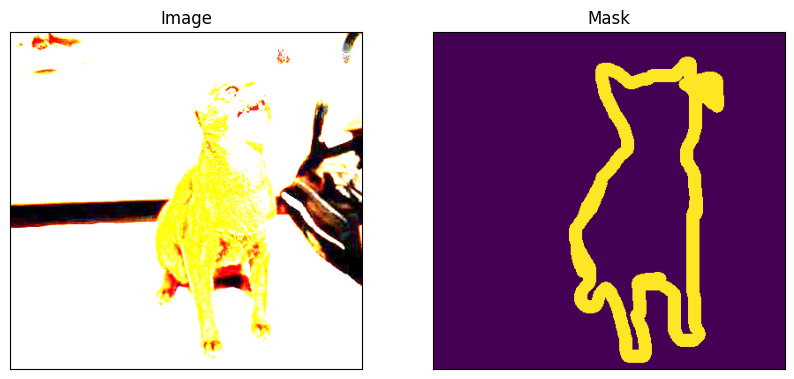

In [150]:
image, mask = test_dataset[1]
visualise_data(image = image, mask = mask)

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 9,                # base font size
    'axes.titlesize': 9,
    'axes.labelsize': 9,           # axis labels
    'xtick.labelsize': 8,          # x tick labels
    'ytick.labelsize': 8,          # y tick labels
    'legend.fontsize': 8,
    'figure.dpi': 300              # high-res export
})
df = pd.read_csv('/Users/georgeboutselis/Downloads/training_log_CE.csv')
df = df.melt(id_vars=['epoch'])
df.head()

,epoch,variable,value
0,1,train_loss,0.891038
1,2,train_loss,0.776474
2,3,train_loss,0.739716
3,4,train_loss,0.710074
4,5,train_loss,0.689929


In [38]:
renaming = {'train_loss': 'CE training loss',
            'val_loss': 'CE Validation Loss',
            'mean_iou': 'mean IoU',
            'accuracy': 'accuracy'
            }


In [39]:
df['variable'] = df['variable'].apply(lambda x: renaming.get(x))

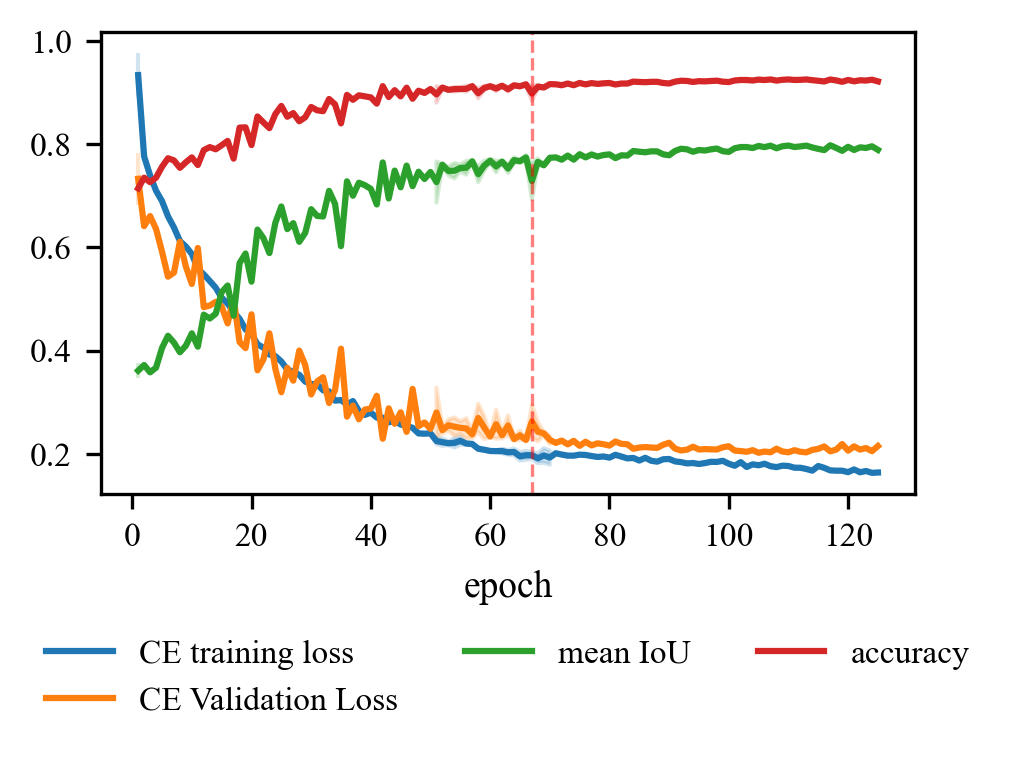

In [57]:
sns.lineplot(data=df, x='epoch', y='value', hue='variable')
plt.axvline(x=67, color='red', linestyle='--', linewidth = 0.8, alpha = 0.5)

# Move legend to bottom
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
           ncol=3, frameon=False)

plt.ylabel('')

fig = plt.gcf()
fig.set_size_inches(3.5, 2)
plt.savefig("graphs/unet_training_CE.pdf", bbox_inches='tight')

## Model testing 

In [10]:
import os
from segmentation.utils import preprocessing
from segmentation.dataset import CVDataset
from segmentation.eval import CVDatasetPredictions
from torch import torch
from segmentation.show import visualise_data

In [11]:
DATA_DIR = 'Dataset/'
x_test_dir = os.path.join(DATA_DIR, 'Test/color')
y_test_dir = os.path.join(DATA_DIR, 'Test/label')

# Getting a list of relative paths to the images (x) and the masks/labels (y)
x_test_fps, y_test_fps = preprocessing.get_testing_paths(x_test_dir, y_test_dir)

preprocessing_fn = preprocessing.get_preprocessing()
test_augmentation = preprocessing.get_validation_augmentation()

In [13]:
test_dataset  = CVDataset(
                x_test_fps,
                y_test_fps,
                preprocessing=preprocessing_fn,
                augmentation=test_augmentation
                )

# preprocessing is just scaling from 255 -> 1 so we need to do on testing
# valid augmentation just resizes to 256 x 416 so we also need for testing

## Your Custom prediction function! (I think you made one a while ago)

In [14]:
def predict(image, model, device="cuda" if torch.cuda.is_available() else "cpu"):
    '''
    Function that makes a predicted mask from the input image.

    # Parameters
        image: image of size (3, H, W)

    # Returns
        predicted mask of size (1, H, W)
    '''
    model.to(device)  # Ensure model is on the correct device
    model.eval()
    
    image = image.to(device)  # Move image to the same device as model

    # pred_logits from resized image (3, H, W) -> (1, 3, H, W)
    with torch.no_grad():  # Disable gradients for inference
        pred_logits = model(image.unsqueeze(0))
        pred_mask = torch.argmax(pred_logits, dim=1)

    return pred_mask

In [15]:
from models.unet_model import UNET
from segmentation.utils import model_utils
# You probably want to load your trained model here or something, depending on how youve set up your predict function
# Just loading empty one for demonstration purposes
unet_model = UNET(3, 3) 
model_utils.load_checkpoint('/Users/georgeboutselis/Downloads/best_model-2.pth', unet_model)

=> Loading checkpoint from /Users/georgeboutselis/Downloads/best_model-2.pth


In [16]:
# Initialise this
test_predictions = CVDatasetPredictions(test_dataset)

In [17]:
# Pass in your custom prediction function
# Remember, when we use set_prediction_fn, we can specifiy the other arguments of our custom prediction function here
# For instance, I have set device = 'mps' because I have device argument in my custom prediction function
# Similar thing for model
test_predictions.set_prediction_fn(predict_fn = predict, device = 'mps', model = unet_model)

## At this point, everything is set up to make predictions

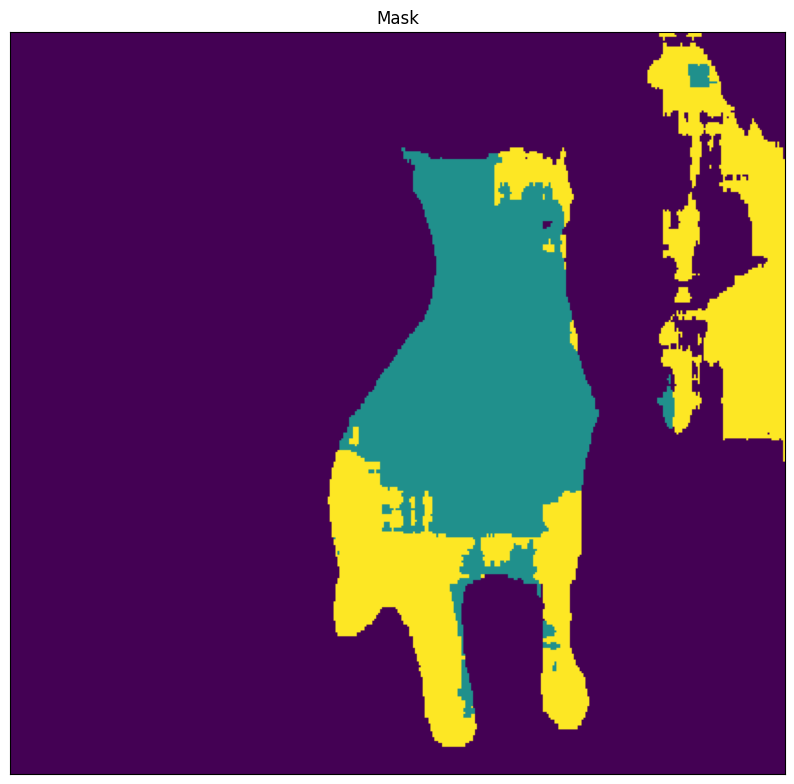

In [18]:
# This is how you make a prediction for the 1st image in the testdataset

predicted_mask = test_predictions.predict(1) 
# Notice how this is on the original dimensions of the image now 
visualise_data(mask = predicted_mask)

## Computing metrics on the test data set on the original domain 

In [19]:
test_predictions.mean_IoU(classes=[0, 1, 2], progress_bar=True)

100%|██████████| 3694/3694 [03:34<00:00, 17.20it/s]


0.79986

In [20]:
test_predictions.compute_accuracy(ignore_class=255, progress_bar=True)

100%|██████████| 3694/3694 [03:12<00:00, 19.18it/s]


0.92992

In [21]:
test_predictions.dice_socre(classes = [0, 1, 2], progress_bar=True)

100%|██████████| 3694/3694 [03:36<00:00, 17.10it/s]


0.88493